In [2]:
!nvidia-smi

Tue Oct 20 04:57:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 16%   36C    P0    47W / 250W |      0MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1B:00.0 Off |                  N/A |
| 16%   40C    P0    68W / 250W |      0MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
import os

#using GPU, comment out if on CPU
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "5"


In [4]:
%load_ext autoreload
%autoreload 2

from halotools.sim_manager import CachedHaloCatalog
from halotools.empirical_models import PrebuiltHodModelFactory
from halotools.mock_observables.two_point_clustering import tpcf
from halotools.mock_observables import return_xyz_formatted_array

from tensorflow_probability import edward2 as ed

import diffhod

from diffhod.components import Zheng07Cens, Zheng07SatsRelaxedBernoulli, NFWProfile

#from flowpm.utils import cic_paint
import tensorflow as tf

%pylab inline

batch mode...


/home/ben.horowitz/miniconda3/envs/dhod2/lib/python3.8/site-packages/diffhod-0.1-py3.8.egg/diffhod/components.py:8: UserWarning: tfp.edward2 module is deprecated and will be removed on 2019-12-01. Use https://github.com/google/edward2 library instead.


Populating the interactive namespace from numpy and matplotlib


In [5]:
#TF2 compatable painter
def cic_paint(mesh, part, weight=None, name="CiCPaint"):
  """
  Paints particules on a 3D mesh.
  Parameters:
  -----------
  mesh: tensor (batch_size, nc, nc, nc)
    Input 3D mesh tensor
  part: tensor (batch_size, npart, 3)
    List of 3D particle coordinates, assumed to be in mesh units if
    boxsize is None
  weight: tensor (batch_size, npart)
    List of weights  for each particle
  """
  with tf.name_scope(name):
    mesh = tf.convert_to_tensor(mesh, name="mesh")
    part = tf.convert_to_tensor(part, name="part")
    if weight is not None:
      weight = tf.convert_to_tensor(weight, name="weight")

    shape = tf.shape(mesh)
    batch_size, nx, ny, nz = shape[0], shape[1], shape[2], shape[3]
    nc = nz

    # Flatten part if it's not already done
    if len(part.shape) > 3:
      part = tf.reshape(part, (batch_size, -1, 3))

    # Extract the indices of all the mesh points affected by each particles
    part = tf.expand_dims(part, 2)
    floor = tf.floor(part)
    connection = tf.expand_dims(tf.constant([[[0, 0, 0], [1., 0, 0],[0., 1, 0],
                                              [0., 0, 1],[1., 1, 0],[1., 0, 1],
                                              [0., 1, 1],[1., 1, 1]]]), 0)

    neighboor_coords = floor + connection
    kernel = 1. - tf.abs(part - neighboor_coords)
    # Replacing the reduce_prod op by manual multiplication
    # TODO: figure out why reduce_prod was crashing the Hessian computation
    kernel = kernel[..., 0] * kernel[..., 1] * kernel[..., 2]

    if weight is not None: kernel = tf.multiply(tf.expand_dims(weight, axis=-1) , kernel)

    neighboor_coords = tf.cast(neighboor_coords, tf.int32)
    neighboor_coords = tf.math.mod(neighboor_coords , nc)

    # Adding batch dimension to the neighboor coordinates
    batch_idx = tf.range(0, batch_size)
    batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1, 1))
    b = tf.tile(batch_idx, [1] + list(neighboor_coords.get_shape()[1:-1]) + [1])
    neighboor_coords = tf.concat([b, neighboor_coords], axis=-1)

    update = tf.scatter_nd(tf.reshape(neighboor_coords, (-1, 8,4)),tf.reshape(kernel, (-1, 8)),[batch_size, nx, ny, nz])
    mesh = mesh + update
    return mesh


In [6]:
def _initialize_pk(shape,boxsize,kmin,dk):
    """
       Helper function to initialize various (fixed) values for powerspectra... not differentiable!
    """
    I = np.eye(len(shape), dtype='int') * -2 + 1

    W = np.empty(shape, dtype='f4')
    W[...] = 2.0
    W[..., 0] = 1.0
    W[..., -1] = 1.0
    kedges = np.arange(kmin, np.pi * 3 / 2 + dk/2, dk)

    k = [np.fft.fftfreq(N, 1. / (N * 2 * np.pi / L))[:pkshape].reshape(kshape) for N, L, kshape, pkshape in zip(shape.as_list(), boxsize, I, shape.as_list())]
    kmag = sum(ki ** 2 for ki in k) ** 0.5

    xsum = np.zeros(len(kedges) + 1)
    Nsum = np.zeros(len(kedges) + 1)

    dig = np.digitize(kmag.flat, kedges)

    xsum.flat += np.bincount(dig, weights=(W * kmag).flat, minlength=xsum.size)
    Nsum.flat += np.bincount(dig, weights=W.flat, minlength=xsum.size)
    dig = tf.convert_to_tensor(dig,dtype=tf.int32)
    Nsum = tf.convert_to_tensor(Nsum,dtype=tf.complex64)
    xsum = tf.convert_to_tensor(np.array(xsum))
    W = tf.convert_to_tensor(np.array(W))
    k = np.array(k)
    kedges = tf.convert_to_tensor(np.array(kedges))
    return dig, Nsum, xsum, W, k, kedges

In [7]:
#updated pk for batch mode...
#@tf.function
def pk(field,kmin=5,dk=0.8,shape = False,boxsize= False):  
    print("traced!")
    """
    Calculate the powerspectra given real space field
    
    Args:
        
        field: real valued field 
        kmin: minimum k-value for binned powerspectra
        dk: differential in each kbin
        shape: shape of field to calculate field (can be strangely shaped?)
        boxsize: length of each boxlength (can be strangly shaped?)
    
    Returns:
        
        kbins: the central value of the bins for plotting
        power: real valued array of power in each bin
        
    """
     
    bs = field.shape[0] #batch size

    dig, Nsum, xsum, W, k, kedges = _initialize_pk(shape,boxsize,kmin,dk)

    #convert field to complex for fft
    field_complex = tf.dtypes.cast(field,dtype=tf.complex64)

    #fast fourier transform
    fft_image = tf.map_fn(tf.signal.fft3d, field_complex)#, dtype=None, parallel_iterations=None, back_prop=True,
    #swap_memory=False, infer_shape=True, name=None
    #)


    #absolute value of fast fourier transform
    pk = tf.math.real(fft_image*tf.math.conj(fft_image))
    #calculating powerspectra
    Psum = tf.zeros(tf.size(kedges) + 1, dtype=tf.complex64)
    real = tf.reshape(tf.math.real(pk),[bs,-1,])
    imag = tf.reshape(tf.math.imag(pk),[bs,-1,])


    #def bincount func

    def bincount(x):
        return tf.math.bincount(dig, weights=(tf.reshape(W,[-1])  * x), minlength=tf.size(xsum))
    #Psum1 = tf.dtypes.cast(tf.vectorized_map(bincount, imag),dtype=tf.complex64)*1j
    #Psum2 = tf.dtypes.cast(tf.vectorized_map(bincount, real),dtype=tf.complex64)
    Psum1 = tf.dtypes.cast(tf.map_fn(
     bincount, imag, dtype=None, parallel_iterations=None, back_prop=True,
     swap_memory=False, infer_shape=True, name=None
     ),dtype=tf.complex64)*1j

    Psum2 = tf.dtypes.cast(tf.map_fn(
     bincount, real, dtype=None, parallel_iterations=None, back_prop=True,
     swap_memory=False, infer_shape=True, name=None
     ),dtype=tf.complex64)


    power = ((Psum + Psum1+Psum2)/ Nsum)[:,1:-1]* boxsize.prod() 

    #normalization for powerspectra
    norm = tf.dtypes.cast(tf.reduce_prod(shape),dtype=tf.float32)**2

    #find central values of each bin
    kbins = kedges[:-1]+ (kedges[1:] - kedges[:-1])/2

    return kbins,tf.dtypes.cast(power,dtype=tf.float32)/norm

In [8]:
# Load a reference halo catalog
halocat = CachedHaloCatalog(simname = 'bolshoi', redshift=0.) 

# Removing subhalos and convert table to tensors
halo_table = halocat.halo_table
halo_table = halo_table[halo_table['halo_pid'] == -1]
halo_table = halo_table[halo_table['halo_x'] < 32]
halo_table = halo_table[halo_table['halo_y'] < 32]
halo_table = halo_table[halo_table['halo_z'] < 32]

tf_halocat = {k: tf.convert_to_tensor(halo_table[k], dtype=tf.float32) for k in halo_table.colnames}

In [9]:
# We first load our reference halotools model
zheng07_model = PrebuiltHodModelFactory('zheng07', redshift =-0, 
                                        modulate_with_cenocc=True)

In [11]:
# Let's see what are the parameters of the model
zheng07_model.param_dict

{'logMmin': 12.02,
 'sigma_logM': 0.26,
 'logM0': 11.38,
 'logM1': 13.31,
 'alpha': 1.06}

In [12]:
# Here is how we define the same model in diffhod
@tf.function
def hod(halo_cat, logMmin, sigma_logM, logM0, logM1, alpha, max_sat=40, temp=0.4,bs=10):
  ### Occupation model ###
  n_cen = Zheng07Cens(halo_cat['halo_mvir'],
                      sigma_logM=sigma_logM,
                      logMmin=logMmin,
                      temperature=temp)
  n_sat = Zheng07SatsRelaxedBernoulli(halo_cat['halo_mvir'],
                                      n_cen,
                                      logM0=logM0,
                                      logM1=logM1,
                                      alpha=alpha,
                                      sample_shape=(max_sat,),
                                      temperature=temp)
  
  ### Phase Space model ###
  # Centrals are just located at center of halo
  pos_cen = ed.Deterministic(tf.stack([halo_cat['halo_x'],
                                        halo_cat['halo_y'],
                                        halo_cat['halo_z']], axis=-1))

  # Satellites follow an NFW profile centered on halos
  pos_sat = NFWProfile(pos=pos_cen,
                        concentration=halo_cat['halo_nfw_conc'],
                        Rvir=halo_cat['halo_rvir'],
                        sample_shape=(max_sat,))
  
  return {'pos_cen':pos_cen,'n_cen':n_cen, 'pos_sat':pos_sat,  'n_sat':n_sat}

In [13]:
#batch compatable painter
@tf.function
def paint_galaxies(gal_cat, nc=32):
    # Take centrals and rescale them to the boxsize
    
    bs = gal_cat['n_sat'].shape[1]
    
    sample1 = gal_cat['pos_cen'] / 32. * nc
    weights1 = gal_cat['n_cen']
    # Take sats and rescale them to the boxize
  
    sample2 = tf.reshape(gal_cat['pos_sat'], [-1,3]) / 32. * nc
    weights2 = tf.reshape(gal_cat['n_sat'],[bs,-1])
    
    sample1_r = tf.tile(tf.expand_dims(sample1,0),[bs,1,1])
    print(sample1_r.shape,weights1.shape)
    rho1 = cic_paint(tf.zeros((bs, nc, nc, nc)),sample1_r, weights1)
    sample2_r = tf.tile(tf.expand_dims(sample2,0),[bs,1,1])
    print(sample2_r.shape,weights2.shape)

    rho2 = cic_paint(tf.zeros((bs, nc, nc, nc)),sample2_r, weights2)
    rho = rho1+rho2
    return rho

In [14]:
# sampling galaxies from the model, with given params
@tf.function
def sample(halo_cat, logMmin, sigma_logM, logM0, logM1, alpha):
    return paint_galaxies(hod(halo_cat,logMmin, sigma_logM, logM0, logM1, alpha))

In [15]:
#check all variables for batch-ness

rho = sample(tf_halocat, [15.02,11.0,10.02], [0.26,0.22,0.40], [10.0,11.,13.0], [10.31,12.0,13.0], [1.06,1.06,1.06])

Tensor("Pow:0", shape=(3,), dtype=float32)
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
(3, 2808, 3) (3, 2808)
(3, 112320, 3) (3, 112320)


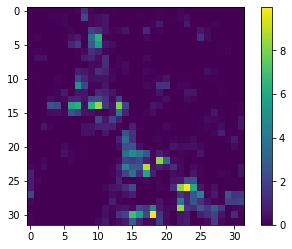

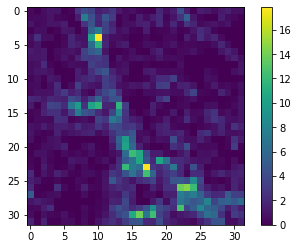

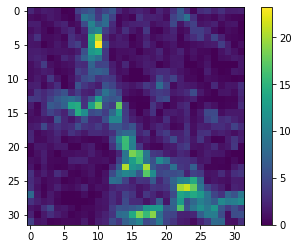

In [16]:

#check that something different is happening :P

imshow(np.array(rho[0]).sum(axis=0))
colorbar()
show()
imshow(np.array(rho[1]).sum(axis=0))
colorbar()
show()

imshow(np.array(rho[2]).sum(axis=0))
colorbar()
show()


In [17]:

%timeit k1, pkr1 = pk(rho, shape=rho[0].shape, boxsize= np.array([32,32,32]), kmin=0.1,dk=.05)


traced!


<ipython-input-6-5ab92cad888c>:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmag = sum(ki ** 2 for ki in k) ** 0.5


traced!
traced!
traced!
traced!
traced!
traced!
traced!
23.6 ms ± 6.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
#fiducial model
rho = sample(tf_halocat, 12.02, 0.26, 11.38, 13.31, 1.06)
k2, pkr2 = pk(rho,
         shape = rho[0].shape, 
         boxsize = np.array([32,32,32]), # WARNING: That's not the right size
         kmin=0.3,dk=.2)

Tensor("Pow:0", shape=(), dtype=float32)
(1, 2808, 3) (1, 2808)
(1, 112320, 3) (1, 112320)
traced!


<ipython-input-6-5ab92cad888c>:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmag = sum(ki ** 2 for ki in k) ** 0.5


In [19]:
pkr2[0]

<tf.Tensor: shape=(22,), dtype=float32, numpy=
array([0.03696533, 0.02201968, 0.01986668, 0.01648097, 0.01319721,
       0.01323627, 0.00972802, 0.00867759, 0.00688746, 0.00607238,
       0.0056512 , 0.00480509, 0.00389127, 0.00323595, 0.00266615,
       0.00226088, 0.00189556, 0.00149653, 0.00120237, 0.00102388,
       0.0008578 , 0.00060291], dtype=float32)>

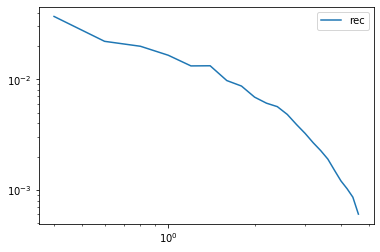

In [20]:
#loglog(k1,pkr1[0], label='data')
loglog(k2,pkr2[0], label='rec')
legend()

In [21]:
# Let's just compute a diagonal cov (takes a while...)

bs = 30
@tf.function
def get_pk(halocat):
    k2, pkr = pk(sample(tf_halocat, 12.02*np.ones(bs,dtype=float32), 0.26*np.ones(bs,dtype=float32), 11.38, 13.31*np.ones(bs,dtype=float32), 1.06*np.ones(bs,dtype=float32) ),
         shape=rho[0].shape, 
         boxsize= np.array([32,32,32]), # WARNING: That's not the right size
         kmin=0.3,dk=.2)
    print(pkr.shape)
    return pkr
import time

start_time = time.time()
samps = [get_pk(halocat) for i in range(10)]
end_time = time.time()- start_time
print(end_time)

Tensor("Pow:0", shape=(), dtype=float32)
(30, 2808, 3) (30, 2808)
(30, 112320, 3) (30, 112320)
traced!
(30, 22)
4.107229471206665


In [22]:
samps = np.stack(samps, axis=0).reshape(300,-1)
diag_std = samps.std(axis=0)
diag_std.shape

(22,)

In [23]:
covar = np.cov(samps.T,bias=False)

In [24]:
np.cov?

In [25]:
inv_covar = np.linalg.inv(covar)/1000

In [26]:
1/diag_std

array([  268.2053 ,   367.08063,   454.03583,   563.34406,   644.41724,
         641.63184,   859.86975,   973.26105,  1228.0121 ,  1503.2615 ,
        1667.4268 ,  1906.042  ,  2461.7715 ,  3054.2195 ,  3837.099  ,
        4495.4116 ,  5177.8135 ,  6688.4326 ,  8368.167  ,  9372.194  ,
       11523.812  , 12898.203  ], dtype=float32)

In [27]:
np.diag(np.array(inv_covar))/1000

array([2.68171672e-01, 6.25106812e-01, 1.66073258e+00, 2.53445048e+00,
       5.77213693e+00, 9.50921125e+00, 1.89213197e+01, 2.62019262e+01,
       3.76094646e+01, 6.62904462e+01, 9.10843702e+01, 1.41069638e+02,
       2.66357415e+02, 4.49616561e+02, 6.88609279e+02, 8.60487559e+02,
       1.26992388e+03, 1.51084120e+03, 1.62691713e+03, 1.73993265e+03,
       1.83061481e+03, 9.48662187e+02])

In [28]:
# Ok sweet, so now we can define these as a function of variables
logM = tf.Variable(12.5)
sig_logM = tf.Variable(0.5)
logM0 = tf.Variable(10.38)
logM1 = tf.Variable(13.01)
alpha = tf.Variable(1.6)

In [29]:
#quick example showing large sample... use this for covariance estimation? might be just as slow with the map_fn

k, pko = pk(sample(tf_halocat, tf.Variable(np.ones(10)*logM,dtype=float32), tf.Variable(sig_logM,dtype=float32), tf.Variable(logM0,dtype=float32), tf.Variable(logM1,dtype=float32), tf.Variable(alpha,dtype=float32)),shape=rho[0].shape, 
     boxsize= np.array([32,32,32]), # WARNING: That's not the right size
     kmin=0.01,dk=.2)



Tensor("Pow:0", shape=(), dtype=float32)
(10, 2808, 3) (10, 2808)
(10, 112320, 3) (10, 112320)
traced!


<ipython-input-6-5ab92cad888c>:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmag = sum(ki ** 2 for ki in k) ** 0.5


In [30]:
mean_val = np.mean(np.array(pko),axis=0)

In [31]:
pko

<tf.Tensor: shape=(10, 24), dtype=float32, numpy=
array([[0.26324078, 0.4217762 , 0.1911821 , 0.1533362 , 0.14268643,
        0.12725376, 0.1408399 , 0.12166011, 0.09436897, 0.07179997,
        0.06228697, 0.05086859, 0.04438134, 0.03691328, 0.02653328,
        0.02042541, 0.01576567, 0.01273165, 0.00942126, 0.00713954,
        0.00539721, 0.00402487, 0.00318651, 0.00251083],
       [0.2971278 , 0.4577998 , 0.20076402, 0.16458008, 0.15272231,
        0.13053733, 0.14922066, 0.12976927, 0.1025968 , 0.0756713 ,
        0.06434611, 0.05258816, 0.04650747, 0.03827358, 0.02681107,
        0.0200861 , 0.01547099, 0.01212211, 0.00905025, 0.00660312,
        0.00487702, 0.00346831, 0.00269369, 0.00215055],
       [0.29694498, 0.43230698, 0.19727686, 0.16154703, 0.14536852,
        0.12573703, 0.13924563, 0.12197591, 0.09635542, 0.07303844,
        0.06147594, 0.0507825 , 0.04457866, 0.03691314, 0.02671763,
        0.02008329, 0.01558454, 0.01229418, 0.00929572, 0.00673547,
        0.00514601, 

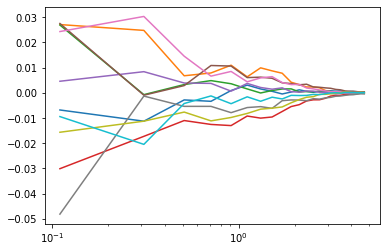

In [32]:
for pki in np.array(pko):
    plt.semilogx(k,(pki-mean_val))

In [33]:
def batch_func(x):
        _, pkr = pk(sample(tf_halocat, np.ones(2,dtype=np.float32)*x[0], np.ones(2,dtype=np.float32)*x[1], 11.38, np.ones(2,dtype=np.float32)*x[2], np.ones(2,dtype=np.float32)*x[3]),#sample(tf_halocat, X[:,0], X[:,1], 11.38, X[:,2], X[:,3]),
                 shape=rho[0].shape, 
                 boxsize= np.array([32,32,32]), # WARNING: That's not the right size
                 kmin=0.3,dk=.2)
        return tf.reduce_mean(pkr,axis=0)

In [34]:
output = batch_func(np.array([12.0,1.01,13.01, 0.20],dtype=np.float32))

Tensor("Pow:0", shape=(), dtype=float32)
(2, 2808, 3) (2, 2808)
(2, 112320, 3) (2, 112320)
traced!


<ipython-input-6-5ab92cad888c>:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmag = sum(ki ** 2 for ki in k) ** 0.5


In [35]:
diag_std

array([3.7284871e-03, 2.7241972e-03, 2.2024694e-03, 1.7751142e-03,
       1.5517897e-03, 1.5585262e-03, 1.1629668e-03, 1.0274736e-03,
       8.1432424e-04, 6.6522026e-04, 5.9972651e-04, 5.2464742e-04,
       4.0621156e-04, 3.2741588e-04, 2.6061354e-04, 2.2244905e-04,
       1.9313171e-04, 1.4951186e-04, 1.1950049e-04, 1.0669860e-04,
       8.6776847e-05, 7.7530181e-05], dtype=float32)

In [57]:
@tf.function
def loss(X):
    pkr = tf.map_fn(batch_func,X)
    #NORMALIZATION IS SCREWED UP!
    return tf.reduce_sum(-1*(pkr - pkr2) @ (1/inv_covar) @ tf.transpose(pkr - pkr2),axis=1)


In [58]:
X_test = tf.Variable(np.array([[12.02, 0.26, 13.31, 1.06],[13.02, 0.26, 13.31, 1.06]],dtype=float32),dtype=float32)

output = loss(X_test)

print(output)

traced!


<ipython-input-6-5ab92cad888c>:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmag = sum(ki ** 2 for ki in k) ** 0.5


tf.Tensor([ 0.00070916 -0.01315916], shape=(2,), dtype=float32)


In [59]:
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
tf.enable_v2_behavior()

num_burnin_steps = int(3e2) #oops....

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=loss,
        num_leapfrog_steps=3,
        step_size=.008),
    num_adaptation_steps=int(num_burnin_steps * 0.8))


In [60]:
var = (np.random.random([100, 4])-0.5)*np.array([0.1,0.02,0.1,0.01])*2.0

In [61]:

num_results = 1000

# Initial state of the chain
num_chains = 100
init_state = tf.Variable(np.ones([num_chains, 4], dtype=dtype)*np.array([12.12, 0.36, 13.21, 1.16],dtype=float32)+var,dtype=float32)

@tf.function
def run_chain():
  # Run the chain (with burn-in).
    samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=init_state,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)

    return samples,is_accepted#sample_mean, sample_stddev, is_accepted


In [ ]:
import time
current_time = time.time()
q,is_accepted = run_chain()
run_time = time.time()-current_time
print(run_time)

traced!


<ipython-input-6-5ab92cad888c>:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmag = sum(ki ** 2 for ki in k) ** 0.5


In [65]:
print(run_time/60/60)

5.464945438702901


In [66]:
q[0]-q[-1]

<tf.Tensor: shape=(100, 4), dtype=float32, numpy=
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.71852112e-03,  7.40757585e-03,  1.39141083e-02,
         1.50787830e-02],
       [ 9.50622559e-03,  3.61792445e-02,  1.43661499e-02,
         7.76934624e-03],
       [ 2.53553391e-02, -2.21324563e-02,  9.83905792e-03,
        -3.77631187e-03],
       [-2.30159760e-02,  1.10605359e-02, -3.47309113e-02,
         1.69515610e-03],
       [ 1.26552582e-02,  2.28056014e-02,  2.48336792e-03,
         1.95016861e-02],
       [-8.72612000e-03,  3.83955240e-03,  6.19888306e-05,
         1.09558105e-02],
       [ 9.14573669e-03,  7.29379058e-03, -8.48102570e-03,
         2.51817703e-02],
       [-2.83622742e-03,  2.17053294e-02, -8.87393951e-03,
        -1.29001141e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-5.20954132e-02,  1.62916183e-02, -7.91301727e-02,
         1.80219412e-02],
       [-1.4871

In [67]:
loss(q[0])

traced!


<ipython-input-6-5ab92cad888c>:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmag = sum(ki ** 2 for ki in k) ** 0.5


<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([ 3.42979789e-01, -1.87465787e-01, -1.37446925e-01, -1.63359255e-01,
       -8.58243927e-02, -1.27894044e-01, -1.69179887e-01, -2.62082458e-01,
       -2.50176609e-01,  2.47839540e-01,  8.24591815e-02, -3.32110405e-01,
        3.12245250e-01, -1.41621381e-01, -1.01545878e-01,  3.44732344e-01,
        1.04839526e-01,  3.46264809e-01,  1.08985350e-01, -3.22045267e-01,
       -3.69443297e-01, -8.56194645e-02,  3.43096793e-01, -1.72539741e-01,
       -2.23446935e-01, -2.93580234e-01,  3.42292935e-01, -9.66461524e-02,
        8.13666433e-02, -4.10333537e-02,  3.11175078e-01, -3.21910441e-01,
       -6.33803725e-01, -2.65665710e-01,  3.47069561e-01,  3.45023334e-01,
       -1.77759588e-01,  3.04400831e-01, -7.95423910e-02, -3.91529918e-01,
        1.78392917e-01, -1.00486629e-01, -1.62946701e-01, -2.93590486e-01,
       -1.91016167e-01, -2.89202482e-03, -2.71527678e-01,  3.52010339e-01,
       -2.16879725e-01,  3.44340205e-01, -1.86593831

In [68]:
(np.array(q[-1])-init_state)

<tf.Tensor: shape=(100, 4), dtype=float32, numpy=
array([[ 9.18123245e-01, -1.72518402e-01,  1.11898136e+00,
         1.05166435e-02],
       [ 6.72035217e-02, -7.34836161e-02, -2.32219696e-02,
         1.21804476e-02],
       [ 5.97095490e-03, -5.99457920e-02, -4.70848083e-02,
        -1.30138516e-01],
       [-6.19401932e-02,  1.37871027e-01, -4.39939499e-02,
        -7.10093975e-02],
       [-1.14946365e-01, -4.38622534e-02,  4.99534607e-02,
        -1.38803720e-01],
       [-8.32538605e-02, -6.84510171e-02,  1.80263519e-02,
        -3.10126543e-02],
       [-3.99742126e-02, -3.63244414e-02, -3.05643082e-02,
        -4.23569679e-02],
       [ 3.83176804e-02, -2.42536664e-02, -8.57763290e-02,
        -4.52016592e-02],
       [-4.54702377e-02, -2.65184045e-02, -5.77325821e-02,
         2.57968903e-03],
       [ 3.82403374e-01, -8.58633220e-02,  4.18290138e-01,
        -7.27984905e-02],
       [ 7.25421906e-02, -4.92628515e-02,  1.82102203e-01,
        -1.23263955e-01],
       [-1.4751

(array([31611., 38433.,  6956.,  4000.,  2000.,  5000.,  9000.,  2000.,
            0.,  1000.]),
 array([11.89638 , 12.09169 , 12.286999, 12.482308, 12.677617, 12.872927,
        13.068236, 13.263545, 13.458855, 13.654163, 13.849473],
       dtype=float32),
 <a list of 10 Patch objects>)

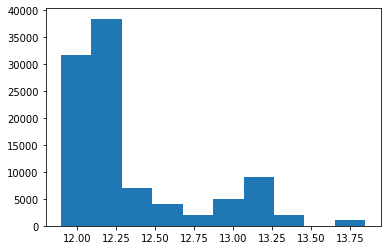

In [69]:
plt.hist(np.array(q).reshape(-1,4)[:,0])

In [70]:
import corner

In [71]:
q.shape

TensorShape([1000, 100, 4])

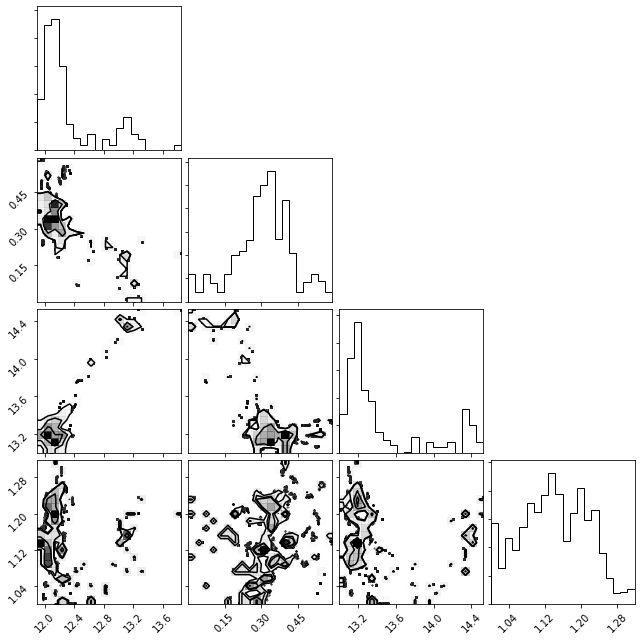

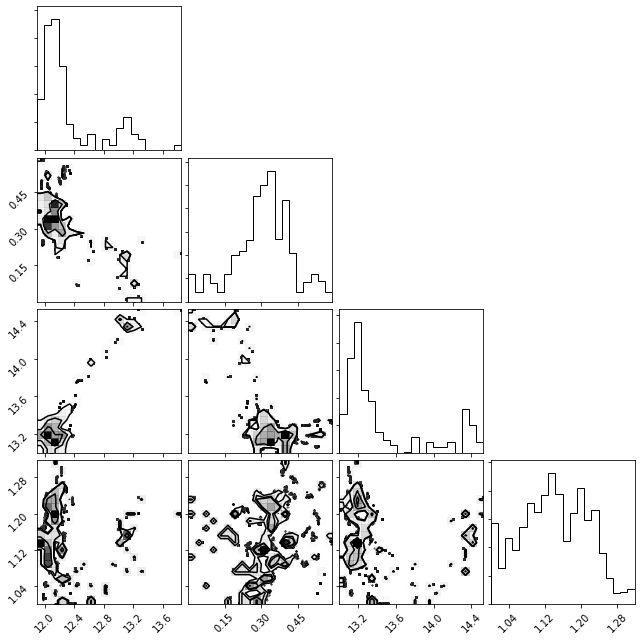

In [72]:
corner.corner(np.array(q[:,:,:]).reshape(-1,4)[:],smooth=0.300)

In [73]:
q.shape

TensorShape([1000, 100, 4])

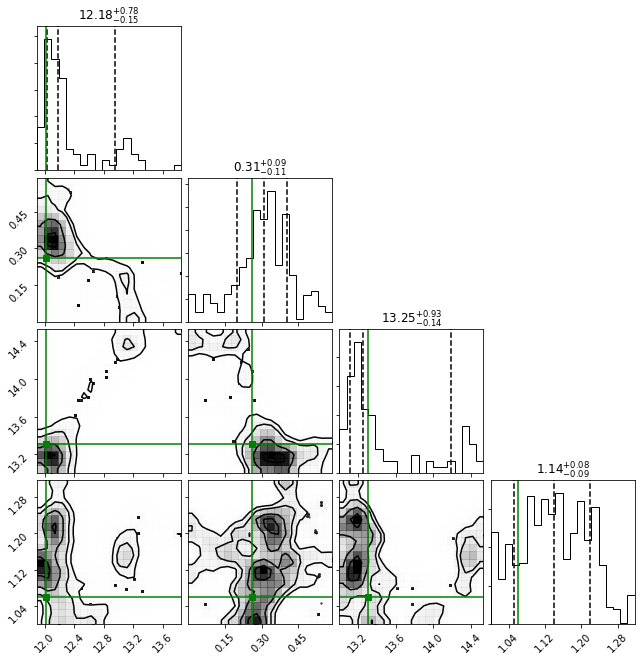

In [76]:
value1 = [12.02, 0.26, 13.31, 1.06]

figure = corner.corner(np.array(q[800:]).reshape(-1,4),quantiles=[0.16, 0.5, 0.84],show_titles=True,smooth=1.00)

ndim = 4
# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(value1[i], color="g")

# Loop over the histograms
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value1[xi], color="g")
        ax.axhline(value1[yi], color="g")
        ax.plot(value1[xi], value1[yi], "sg")


In [ ]:

nc = 10
x = np.linspace(11.5,13,10)
y = np.linspace(0.05,2.5,20)#np.meshgrid(np.arange(nc),np.arange(nc),np.arange(nc))
#self.RSD_grid = np.array(np.vstack([x.flatten(),y.flatten(),z.flatten()]).T,dtype=np.float32).reshape(1, nc**3, 3)
        

In [ ]:
x,y = np.meshgrid(x,y)

In [ ]:
grid = np.array(np.vstack([x.flatten(),y.flatten()]),dtype=float32)
        

In [ ]:
arr = []
for n,i in enumerate(grid.T):
    outi = loss(tf.Variable(i * np.ones((2,2),dtype=float32)))
    print(n,i,np.array(outi).mean())
    arr.append(outi)

In [ ]:
out = np.array(arr)

In [ ]:
means = out.mean(axis=1)

In [ ]:
imshow(np.log10(-means.reshape(20,10)))
colorbar()

In [ ]:
plt.arr[0]